##Apple Stock market Prediction for Future 3 months

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [23]:
#Read the csv file
df = pd.read_csv('/content/AAPL.csv')
df #7 columns, including the Date. 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-17,128.899994,129.580002,128.039993,128.699997,127.911461,94359800
1,2020-12-18,128.960007,129.100006,126.120003,126.660004,125.883957,192541500
2,2020-12-21,125.019997,128.309998,123.449997,128.229996,127.444321,121251600
3,2020-12-22,131.610001,134.410004,129.649994,131.880005,131.071976,168904800
4,2020-12-23,132.160004,132.429993,130.779999,130.960007,130.157608,88223700
...,...,...,...,...,...,...,...
248,2021-12-13,181.119995,182.130005,175.529999,175.740005,175.740005,153237000
249,2021-12-14,175.250000,177.740005,172.210007,174.330002,174.330002,139380400
250,2021-12-15,175.110001,179.500000,172.309998,179.300003,179.300003,131063300
251,2021-12-16,179.279999,181.139999,170.750000,172.259995,172.259995,150185800


In [5]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates

238   2021-11-29
239   2021-11-30
240   2021-12-01
241   2021-12-02
242   2021-12-03
243   2021-12-06
244   2021-12-07
245   2021-12-08
246   2021-12-09
247   2021-12-10
248   2021-12-13
249   2021-12-14
250   2021-12-15
251   2021-12-16
252   2021-12-17
Name: Date, dtype: datetime64[ns]


In [6]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [7]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

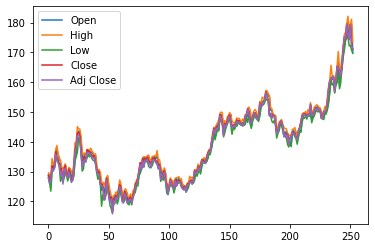

In [8]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [9]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [10]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

In [11]:
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [12]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (239, 14, 5).
trainY shape == (239, 1).


In [13]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))


In [94]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [95]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
14/14 [==============================] - 9s 236ms/step - loss: 0.0427 - val_loss: 0.4350
Epoch 2/5
14/14 [==============================] - 1s 98ms/step - loss: 0.0457 - val_loss: 0.5031
Epoch 3/5
14/14 [==============================] - 1s 97ms/step - loss: 0.0479 - val_loss: 0.5957
Epoch 4/5
14/14 [==============================] - 2s 171ms/step - loss: 0.0376 - val_loss: 0.3624
Epoch 5/5
14/14 [==============================] - 1s 102ms/step - loss: 0.0382 - val_loss: 0.3293


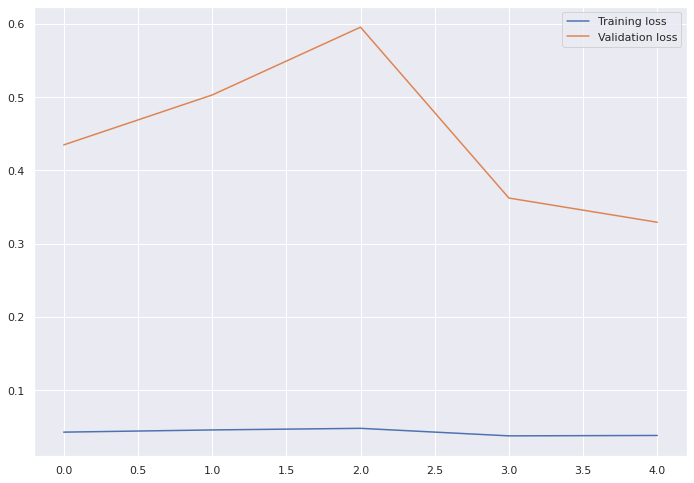

In [96]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [97]:
future = 90
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=future, freq='1d').tolist()

In [98]:
len(forecast_period_dates)

90

In [99]:
trainX[-90:]

array([[[0.64435444, 0.60799051, 0.70959063, 0.70858292, 0.69682687],
        [0.70035004, 0.69255692, 0.7706255 , 0.74167614, 0.72938449],
        [0.76645516, 0.64532205, 0.60238862, 0.57082547, 0.56129975],
        ...,
        [0.53936237, 0.45409471, 0.6000412 , 0.51849225, 0.52638639],
        [0.55802793, 0.53104322, 0.58282614, 0.48078275, 0.48923211],
        [0.5276971 , 0.45561874, 0.60082331, 0.50079189, 0.50894653]],

       [[0.70035004, 0.69255692, 0.7706255 , 0.74167614, 0.72938449],
        [0.76645516, 0.64532205, 0.60238862, 0.57082547, 0.56129975],
        [0.43125998, 0.47466521, 0.36685556, 0.43306695, 0.42577148],
        ...,
        [0.55802793, 0.53104322, 0.58282614, 0.48078275, 0.48923211],
        [0.5276971 , 0.45561874, 0.60082331, 0.50079189, 0.50894653],
        [0.53858504, 0.633132  , 0.62508055, 0.7339797 , 0.73870288]],

       [[0.76645516, 0.64532205, 0.60238862, 0.57082547, 0.56129975],
        [0.43125998, 0.47466521, 0.36685556, 0.43306695, 0.4

In [100]:
forecast = model.predict(trainX[-90:])

In [101]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [102]:
forecast_copies.shape

(90, 5)

In [103]:
y_pred_future.shape

(90,)

In [104]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [105]:
len(forecast_dates)

90

In [106]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [107]:
df_forecast['Date']

0    2021-12-17
1    2021-12-18
2    2021-12-19
3    2021-12-20
4    2021-12-21
        ...    
85   2022-03-12
86   2022-03-13
87   2022-03-14
88   2022-03-15
89   2022-03-16
Name: Date, Length: 90, dtype: datetime64[ns]

In [108]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-12-18']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [109]:
original

,Date,Open
1,2020-12-18,128.960007
2,2020-12-21,125.019997
3,2020-12-22,131.610001
4,2020-12-23,132.160004
5,2020-12-24,131.320007
...,...,...
248,2021-12-13,181.119995
249,2021-12-14,175.250000
250,2021-12-15,175.110001
251,2021-12-16,179.279999


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


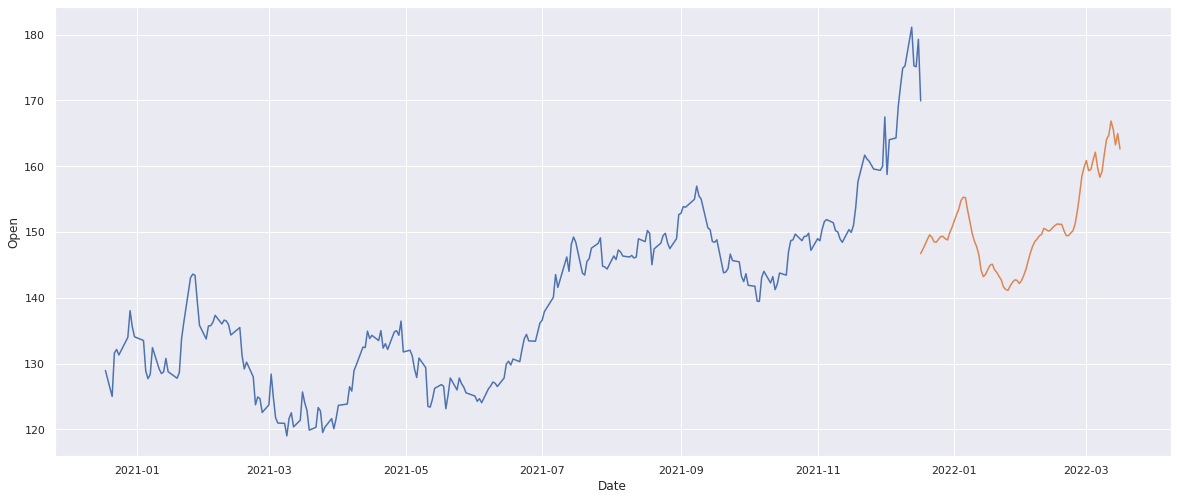

In [111]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])